In [22]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import functools
from itertools import product

import pandas_ta as ta
import skfuzzy as fuzz
from fuzzy_expert.rule import FuzzyRule
from fuzzy_expert.variable import FuzzyVariable
from fuzzy_expert.inference import DecompositionalInference
from fuzzy_expert.plots import plot_crisp_input
from pygad import GA
import time

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

################################### Functions ###############################################
def read_series(name:str):
    folder = os.path.join(os.getcwd(), 'time_series')
    return pd.read_csv(folder + f'/{name}_weekly.csv')



def technical_append(time_series,indicator:list[str]):
    time_series = time_series.copy()
    if 'STO' in indicator:
        STO_k = 14
        STO_d = 3
        time_series = pd.concat([time_series,time_series.ta.stoch(high='High', low='Low', k=STO_k, d=STO_d)],axis = 1)
        del time_series[f'STOCHd_{STO_k}_{STO_d}_{STO_d}']
        time_series = time_series.rename(columns={f'STOCHk_{STO_k}_{STO_d}_{STO_d}':'STO'})    
    time_series = time_series[['Date','Close','STO']]
    if 'RSI' in indicator:
        rsi_length = 14
        time_series = pd.concat([time_series,time_series.ta.rsi(close='Close', length=rsi_length)],axis = 1)
        time_series = time_series.rename(columns={f'RSI_{rsi_length}':'RSI'})
    if 'MACD' in indicator:
        MACD_fast = 12
        MACD_slow = 26
        MACD_signal = 9
        time_series = pd.concat([time_series,time_series.ta.macd(close='Close', fast=MACD_fast, slow=MACD_slow, signal=MACD_signal)],axis = 1)
        del time_series[f'MACDs_{MACD_fast}_{MACD_slow}_{MACD_signal}']
        del time_series[f'MACD_{MACD_fast}_{MACD_slow}_{MACD_signal}']
        time_series = time_series.rename(columns={f'MACDh_{MACD_fast}_{MACD_slow}_{MACD_signal}':'MACD'})

    return time_series.dropna().reset_index(drop=True)
        
def train_test_split(indicator_matrix: pd.DataFrame,train_split,index):
    if index == 'train':
        train = indicator_matrix[:int(len(indicator_matrix)*train_split)]
        return train
    elif index == 'test':
        test = indicator_matrix[int(len(indicator_matrix)*train_split):]
        return test


def fuzzy_variables(list_param:list):
    parameters = list_param
    variables = {
    "RSI": FuzzyVariable(
        universe_range=(RSI_range[0], RSI_range[1]),
        terms={
            "Low": [(i,fuzz.gaussmf(i,parameters[0],parameters[1])) for i in np.arange(RSI_range[0],RSI_range[1])],
            "Med": [(i,fuzz.gaussmf(i,parameters[2],parameters[3])) for i in np.arange(RSI_range[0],RSI_range[1])],
            "High": [(i,fuzz.gaussmf(i,parameters[4],parameters[5])) for i in np.arange(RSI_range[0],RSI_range[1])],
        },
    ),
    "MACD": FuzzyVariable(
        universe_range=(MACD_range[0], MACD_range[1]),
        terms={
            "Low": [(i,fuzz.gaussmf(i,parameters[6],parameters[7])) for i in np.arange(MACD_range[0],MACD_range[1])],
            "Med": [(i,fuzz.gaussmf(i,parameters[8],parameters[9])) for i in np.arange(MACD_range[0],MACD_range[1])],
            "High": [(i,fuzz.gaussmf(i,parameters[10],parameters[11])) for i in np.arange(MACD_range[0],MACD_range[1])],
        },
    ),
    "STO": FuzzyVariable(
        universe_range=(STO_range[0], STO_range[1]),
        terms={
            "Low": [(i,fuzz.gaussmf(i,parameters[12],parameters[13])) for i in np.arange(STO_range[0],STO_range[1])],
            "Med": [(i,fuzz.gaussmf(i,parameters[14],parameters[15])) for i in np.arange(STO_range[0],STO_range[1])],
            "High": [(i,fuzz.gaussmf(i,parameters[16],parameters[17])) for i in np.arange(STO_range[0],STO_range[1])],
        },
    ),
    "Decision": FuzzyVariable(
        universe_range=(Decision_range[0], Decision_range[1]),
        terms={
            "Sell": [(element,fuzz.trapmf(np.arange(Decision_range[0], Decision_range[1]), Decision_Sell)[i]) for i,element in enumerate(np.arange(Decision_range[0], Decision_range[1]))],
            "Buy": [(element,fuzz.trapmf(np.arange(Decision_range[0], Decision_range[1]), Decision_Buy)[i]) for i,element in enumerate(np.arange(Decision_range[0], Decision_range[1]))],
 
         },
    )}

    return variables

    

def Defuzzification(frame: pd.DataFrame ,fuzzy_parameters:list):
    frame['Defuzzification'] = frame.apply(lambda x: model(
    variables=fuzzy_variables(fuzzy_parameters),
    rules=rules,
    MACD = x['MACD'], 
    RSI=x['RSI'],
    STO=x['STO'])[0]['Decision'], axis=1)
    return frame


def total_gain(data_frame: pd.DataFrame, treshold: float):
    data_frame = data_frame.copy()
    data_frame["Direction"] = 0
    data_frame["Direction"] = np.select(
        condlist=[
            data_frame["Defuzzification"] < treshold,
            data_frame["Defuzzification"] >= treshold
        ], choicelist=[-1, 1], default=0
    )
    data_frame['Direction'] = data_frame['Direction'].replace(to_replace=0, method='ffill')
    data_frame['Enter_price'] = data_frame.loc[data_frame['Direction']!=data_frame['Direction'].shift(1), 'Close']
    data_frame['Enter_price'] = data_frame['Enter_price'].fillna(method="ffill")
    data_frame.dropna(inplace=True)
    data_frame['Long'] = np.select(
        condlist=[
            (data_frame['Direction'] > 0) & (data_frame['Direction'].shift(1) != 0) & \
                            (data_frame['Direction'].shift(1) != np.nan) & \
                          (data_frame['Direction'].shift(-1) < 0)
        ], choicelist=[
            ((data_frame["Enter_price"].shift(-1) - data_frame["Enter_price"])/data_frame["Enter_price"])*100,
        ]
    )
    data_frame['Short'] = np.select(
        condlist=[
            (data_frame['Direction'] < 0) & (data_frame['Direction'].shift(1) != 0) & \
                            (data_frame['Direction'].shift(1) != np.nan) & \
                          (data_frame['Direction'].shift(-1) > 0)
        ], choicelist=[
            ((data_frame["Enter_price"] - data_frame["Enter_price"].shift(-1))/data_frame["Enter_price"])*100
        ]
    )
    data_frame['Equity_long'] = data_frame['Long'].cumsum()
    data_frame['Equity_short'] = data_frame['Short'].cumsum()
    data_frame['Gain'] = data_frame['Equity_long']+data_frame['Equity_short']
    return data_frame

def calculate_sharpe_ratio(returns, risk_free_rate=0.03):
    excess_returns = returns - risk_free_rate
    avg_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns)
    if std_excess_return == 0:
        return 0
    return avg_excess_return / std_excess_return





In [23]:


############################################## Fuzzy Rules ######################################

rules = [
    FuzzyRule(
        premise=[
            ("MACD", "High"),
            ("AND","RSI", "Low"),
            ("AND","STO", "Low"),

        ],
        consequence=[("Decision", "Buy")],
    ),
    FuzzyRule(
        premise=[
            ("MACD", "Low"),
            ("AND","RSI", "High"),
            ("AND","STO", "High"),

        ],
        consequence=[("Decision", "Buy")],
    ),
    FuzzyRule(
        premise=[
            ("MACD", "High"),
            ("AND","RSI", "Med"),
            ("AND","STO", "Med"),
            
        ],
        consequence=[("Decision", "Buy")],
    ),
    FuzzyRule(
        premise=[
            ("MACD", "Low"),
            ("AND","RSI", "Med"),
            ("AND","STO", "High"),
        ],
        consequence=[("Decision", "Sell")],
    ),
    FuzzyRule(
        premise=[
            ("RSI", "High"),
            ("AND","STO", "Low"),
        ],
        consequence=[("Decision", "Sell")],
    ),
    FuzzyRule(
        premise=[
            ("MACD", "Low"),
            ("AND","RSI", "High"),
            ("AND","STO", "High"),
        ],
        consequence=[("Decision", "Sell")])]

model = DecompositionalInference(
    and_operator="min",
    or_operator="max",
    implication_operator = 'Rc',
    composition_operator="max-min",
    production_link="max",
    defuzzification_operator="cog",
)




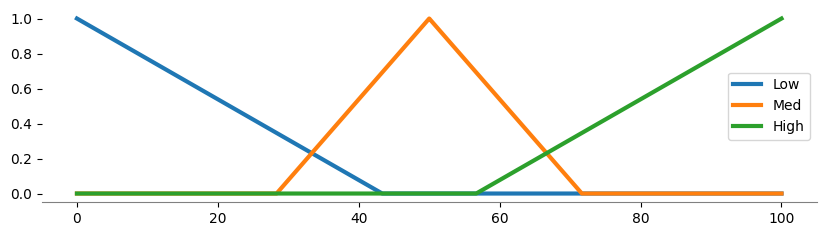

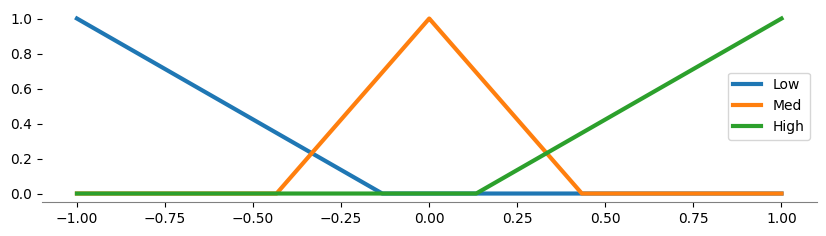

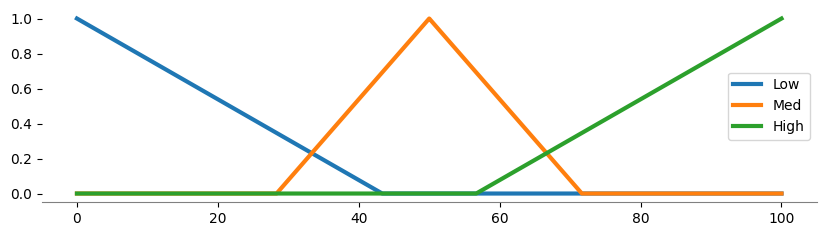

Start train


/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(
/var/folders/

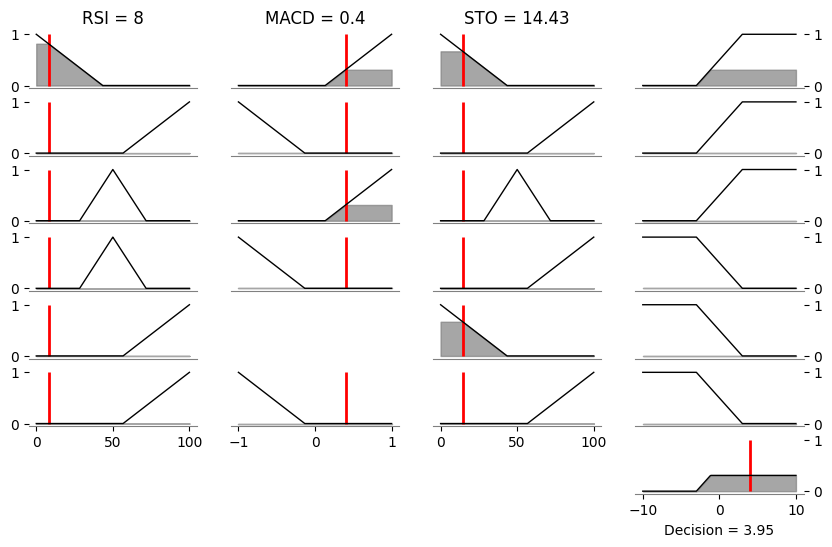

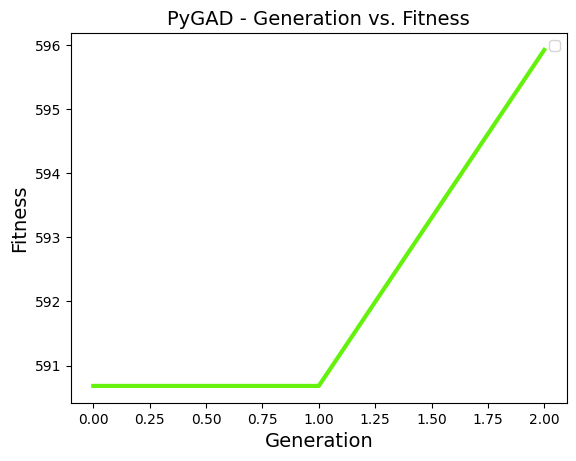

End_train in 130.25699377059937 seconds


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


best_solution: [  0.          43.33333333  28.33333333  71.66666667  56.66666667
 100.54872044  -1.          -0.13333333  -0.43333333   0.43333333
   0.13333333   1.          -0.52528703  43.33333333  28.33333333
  71.66666667  56.66666667 100.           0.        ]
best_solution_fitness: 595.9280226943099


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


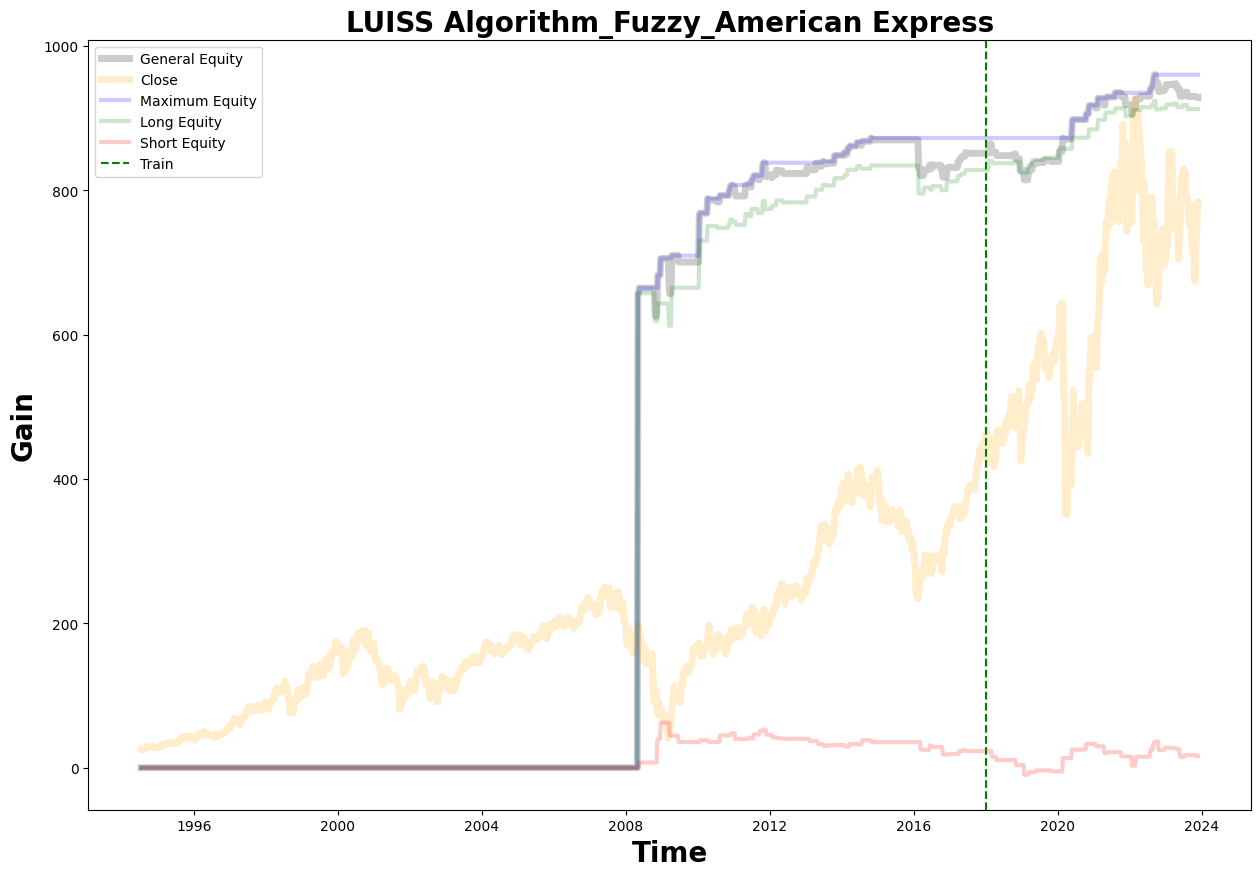

Start train


/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(
/var/folders/

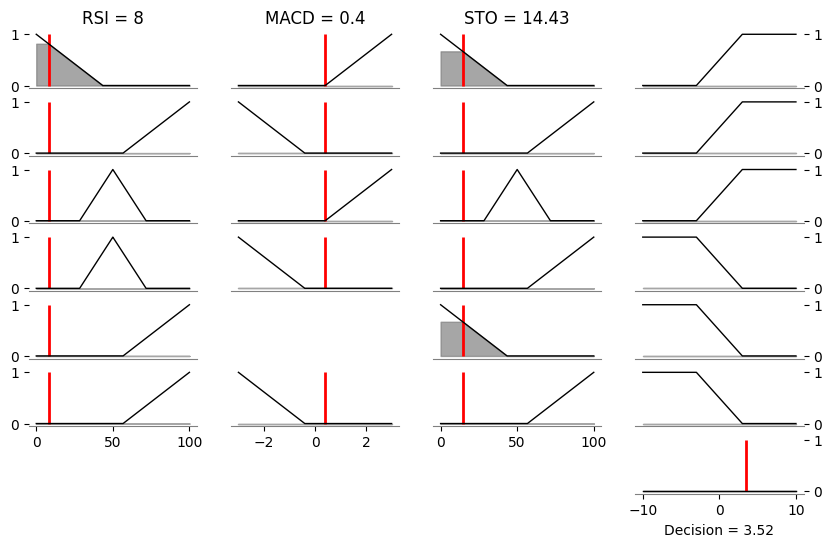

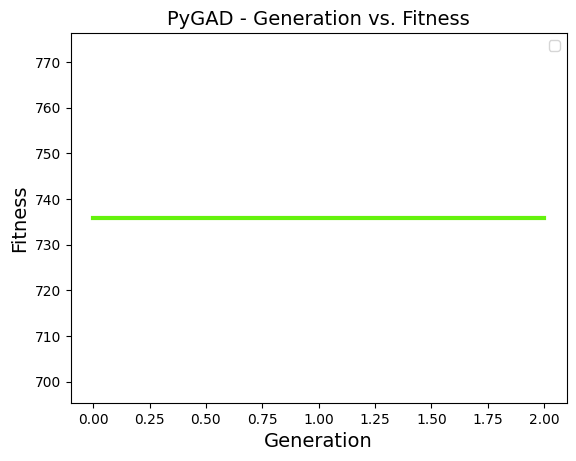

End_train in 132.47779297828674 seconds


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


best_solution: [  0.          43.33333333  28.33333333  71.66666667  56.66666667
  99.49856722  -3.          -0.4         -1.3          1.3
   0.4          3.           0.          43.33333333  28.33333333
  71.66666667  56.66666667 100.           0.        ]
best_solution_fitness: 735.8725452295687


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


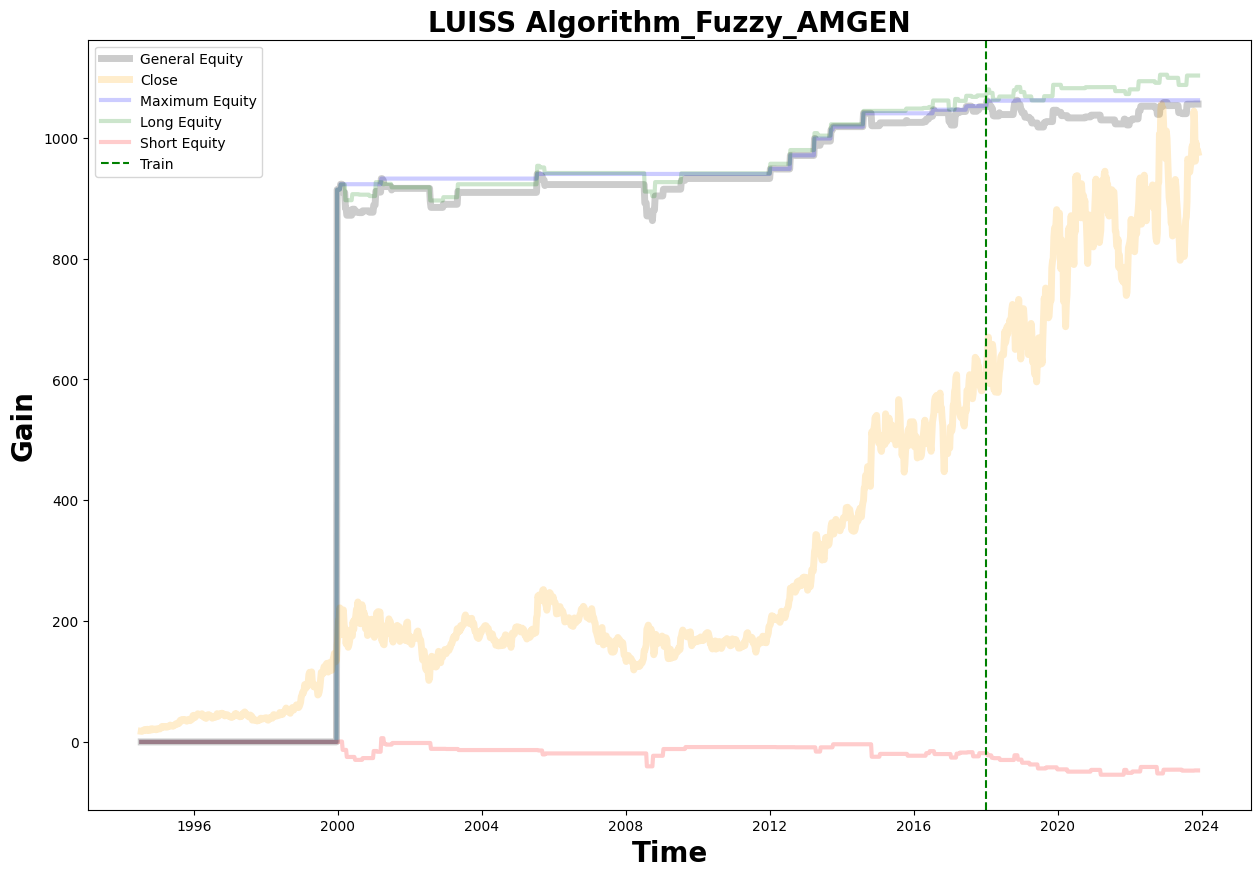

Start train


/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(
/var/folders/

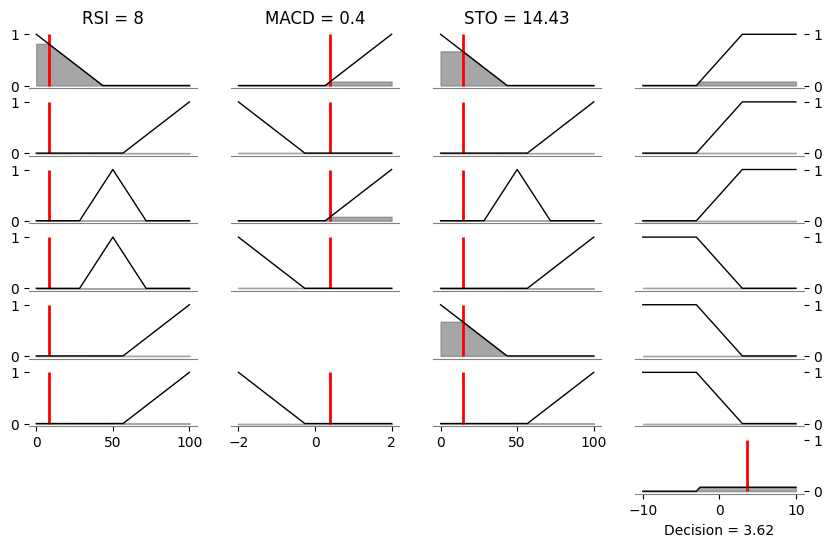

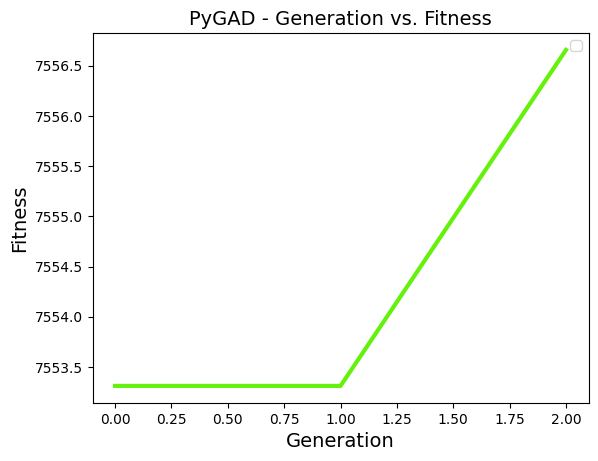

End_train in 129.12563109397888 seconds


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


best_solution: [ 7.14579863e-02  4.33333333e+01  2.83333333e+01  7.16666667e+01
  5.66666667e+01  1.00000000e+02 -2.00000000e+00 -2.66666667e-01
 -8.66666667e-01  8.66666667e-01 -4.01059552e-01  2.00000000e+00
  0.00000000e+00  4.33333333e+01  2.83333333e+01  7.16666667e+01
  5.66666667e+01  1.00000000e+02  0.00000000e+00]
best_solution_fitness: 7556.658072108601


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


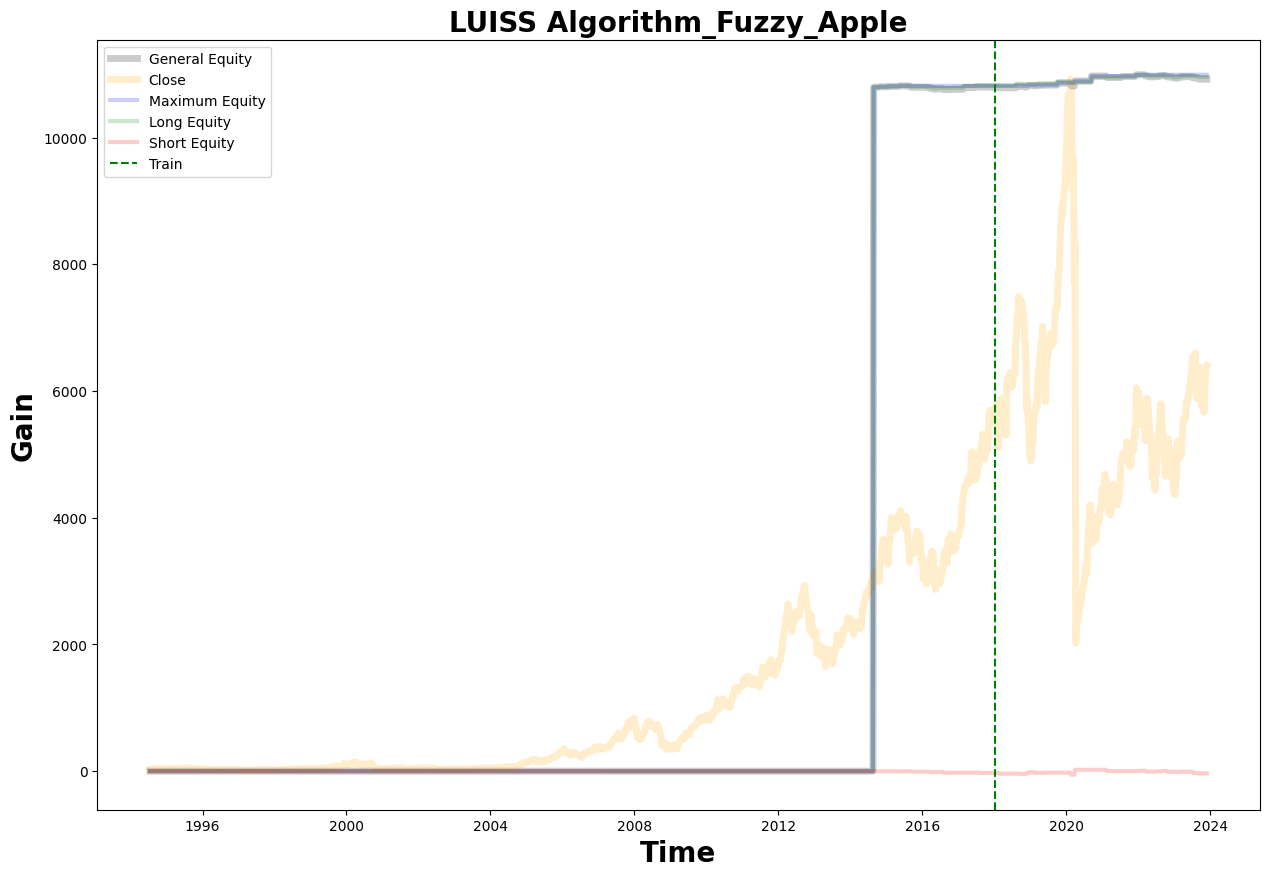

Start train


/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(
/var/folders/

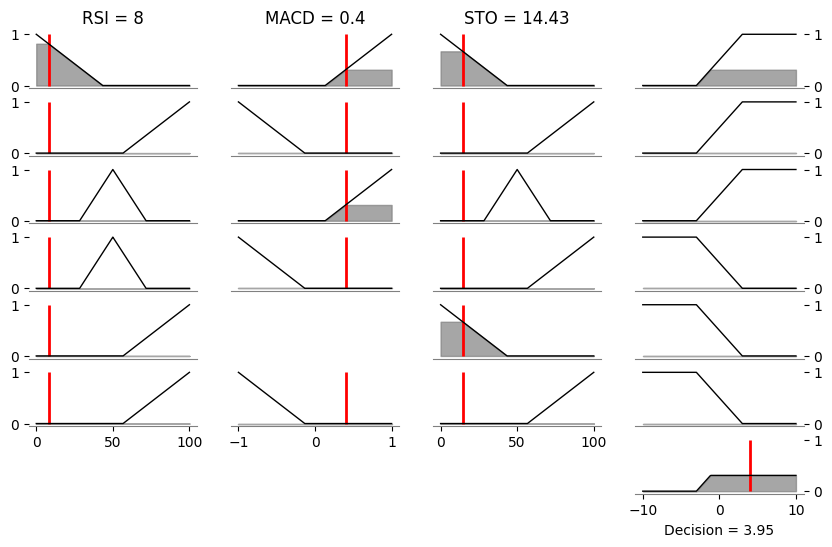

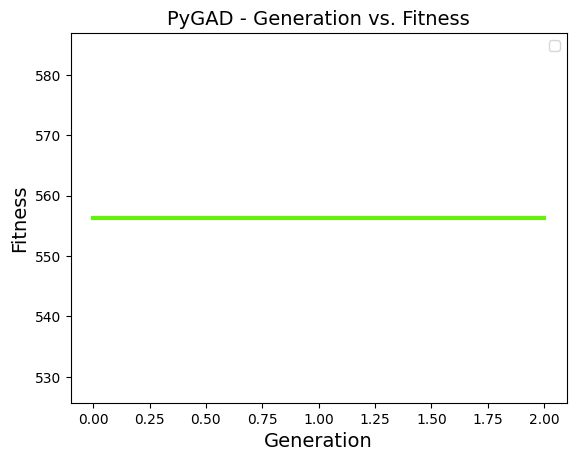

End_train in 127.53905177116394 seconds


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


best_solution: [  0.          43.33333333  28.33333333  71.48599224  56.66666667
 100.          -1.          -0.13333333  -0.43333333   0.43333333
   0.13333333   1.           0.          43.33333333  28.33333333
  71.66666667  56.66666667 100.           0.        ]
best_solution_fitness: 556.309763962694


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


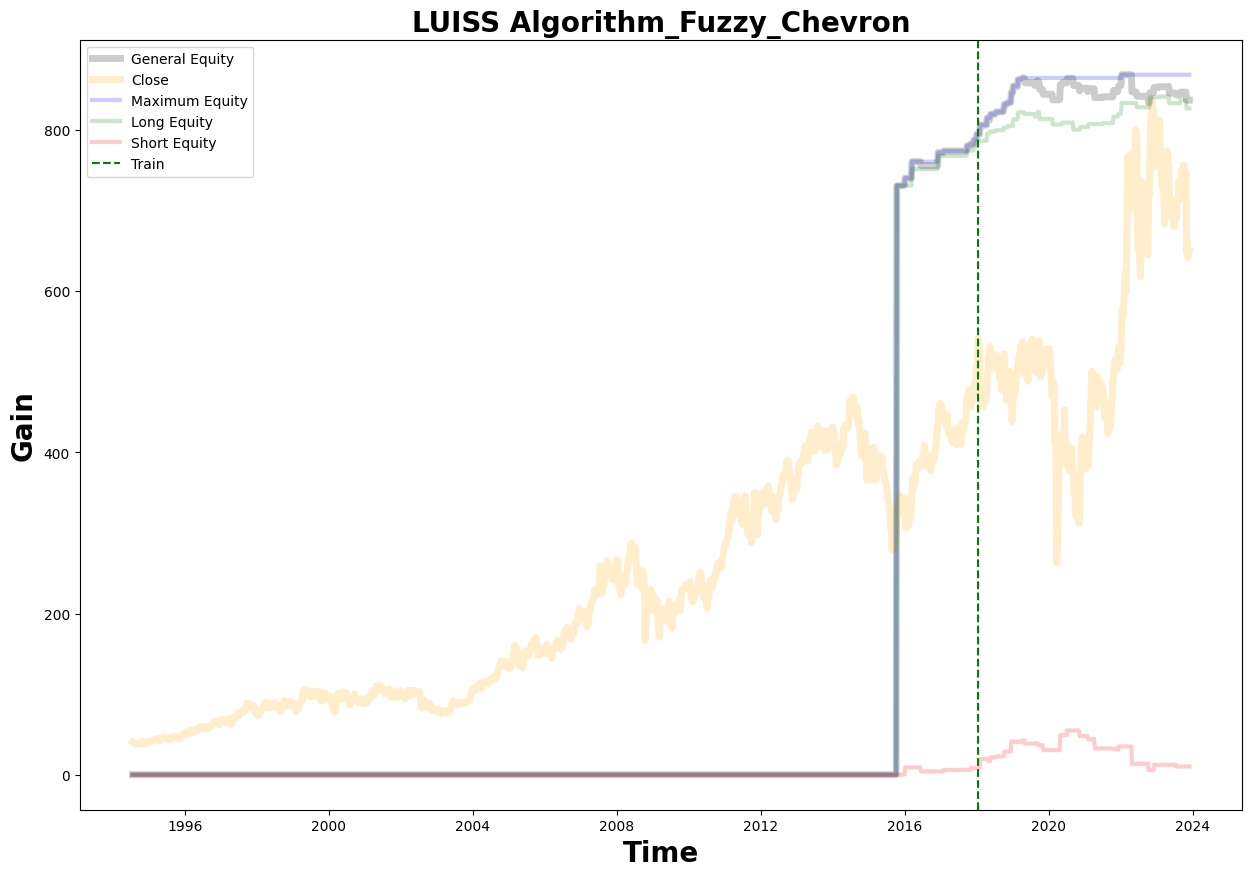

Start train


/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(
/var/folders/

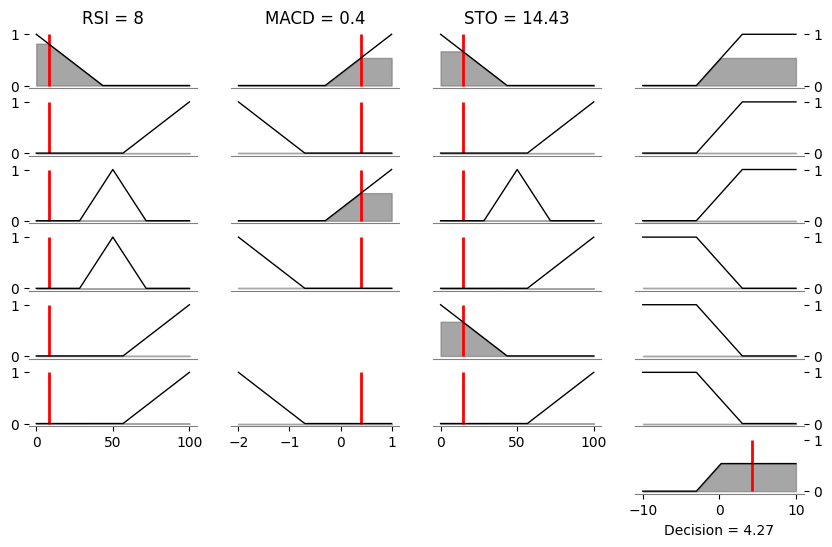

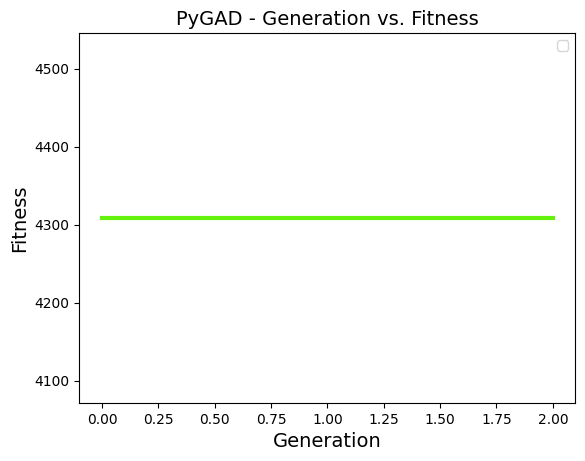

End_train in 128.01233315467834 seconds


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


best_solution: [  0.          43.33333333  28.33333333  71.66666667  56.66666667
 100.          -2.          -0.7         -1.15         0.15
  -0.3          1.           0.          43.33333333  28.33333333
  71.66666667  56.66666667  99.74964315   0.        ]
best_solution_fitness: 4308.653303689332


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


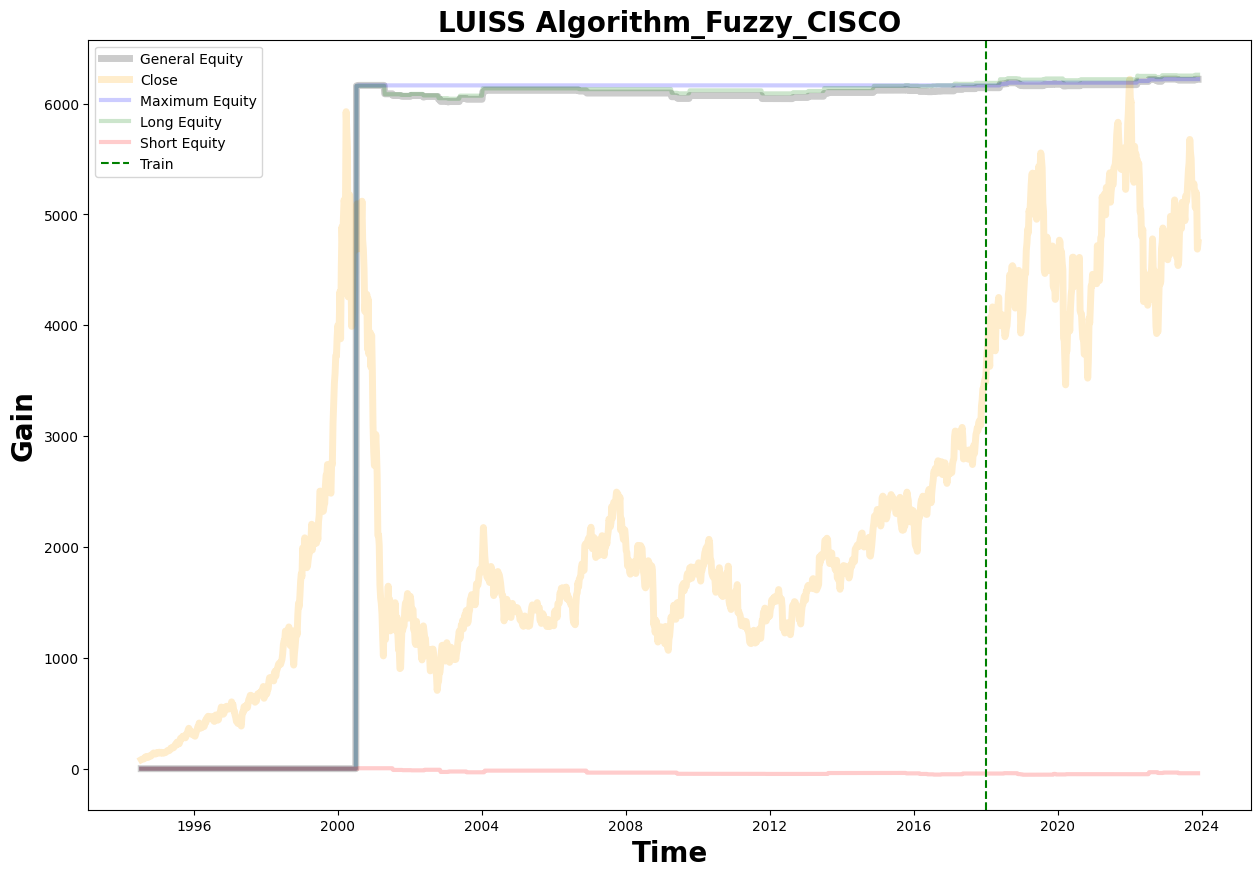

Start train


/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(
/var/folders/

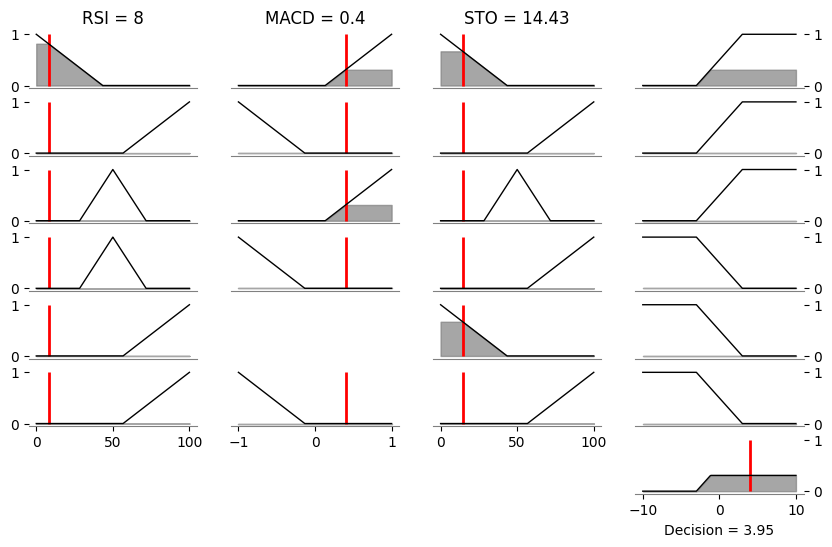

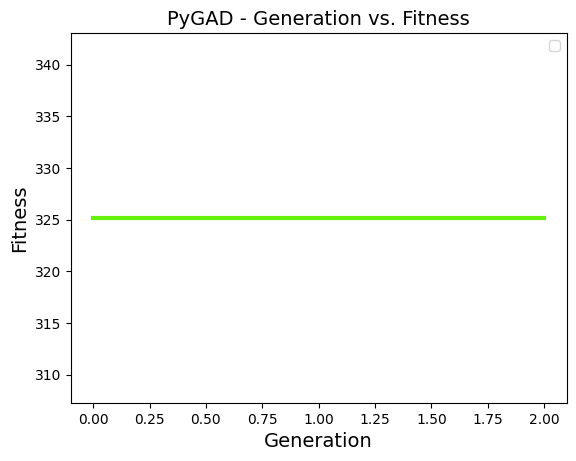

End_train in 130.12508988380432 seconds


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


best_solution: [  0.82594346  43.33333333  28.33333333  71.66666667  56.66666667
 100.          -1.          -0.13333333  -0.43333333   0.43333333
   0.13333333   1.           0.          43.33333333  28.33333333
  71.66666667  56.66666667 100.           0.        ]
best_solution_fitness: 325.1574177199655


/var/folders/4n/w20v1m9d2sq76wl2jmtfbq2c0000gn/T/ipykernel_46853/1307882763.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['Defuzzification'] = frame.apply(lambda x: model(


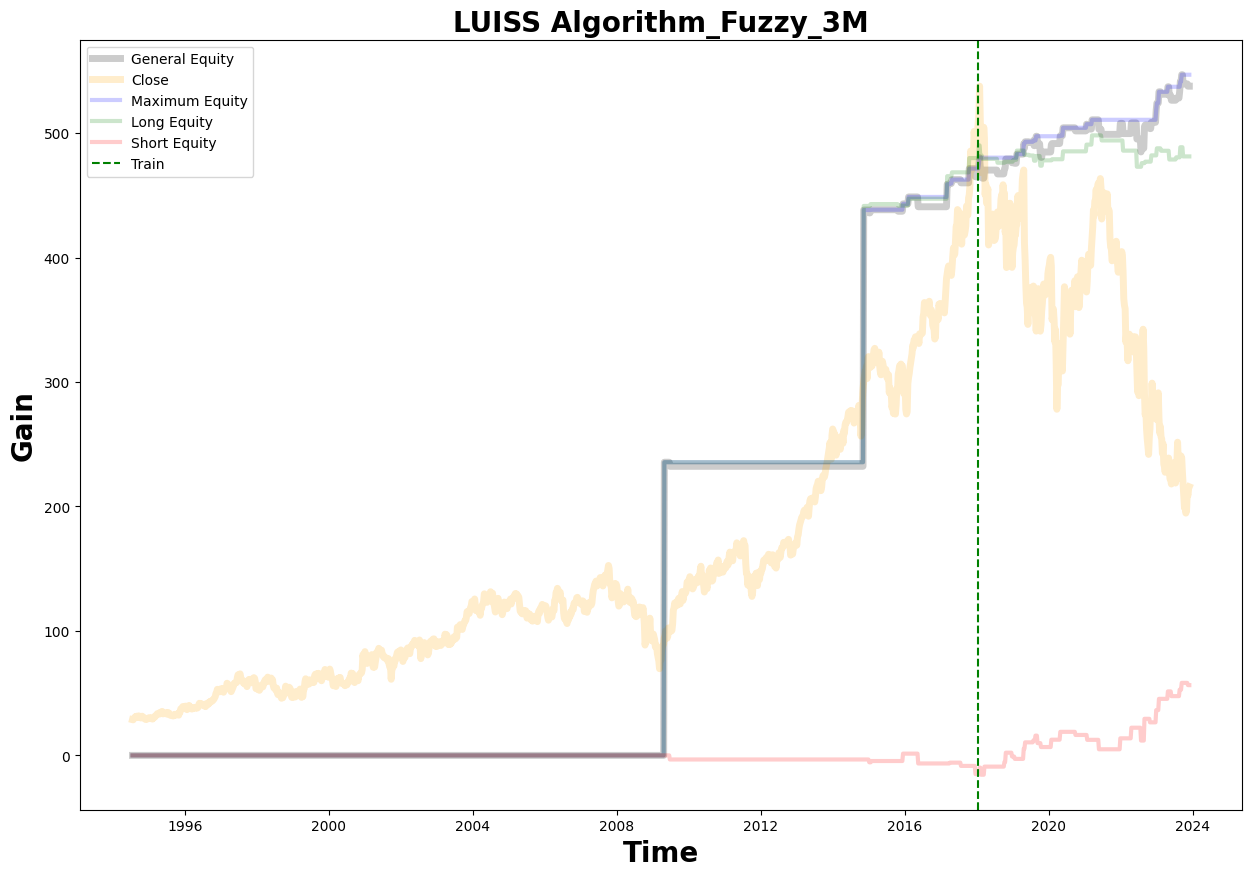

In [24]:


############################################# Variable Definition ##########################################


list_series = ['American Express','AMGEN','Apple','Chevron', 'CISCO',  '3M']
results = [0 for i in range(len(list_series))]
def fitness_func(ga_instance, list_param,RSI_range):
        # Perform defuzzification on the training data using the given parameters
        train_frame = Defuzzification(train, list_param)
        
        # Calculate total gain from the defuzzified results
        total_gain_value = total_gain(train_frame, list_param[-1])['Gain'].iloc[-1]
        
        # Calculate returns (daily returns in this case)
        returns = train_frame['Close'].pct_change().dropna()
        
        # Calculate the Sharpe ratio
        sharpe_ratio = calculate_sharpe_ratio(returns)
        
        # Define weights for the objectives (these can be adjusted based on the importance)
        weight_gain = 0.7
        weight_sharpe = 0.3
            
            # Combine the objectives into a single fitness value
        fitness_value = (weight_gain * total_gain_value) + (weight_sharpe * sharpe_ratio)
        
        return fitness_value


for index in range( len(list_series)):
    list_indicators = ['RSI','MACD','STO']
    mode = 'train'
    split_percentage = 0.8
    technical_indicators = technical_append(read_series(list_series[index]),list_indicators)
    train = train_test_split(technical_indicators,split_percentage,mode)

    variation_coeff = 0.2

    #Decision
    Decision_range = [-10, 10]

    Decision_Sell = [-10,-10,-3,3]
    Decision_Buy = [-3,3,10,10]


    overlap_fraction = 0.15

    def get_levels(range_start, range_end):
        R = range_end - range_start
        O = overlap_fraction * R
        N = (R - O) / 3

        # Low level from range_start to range_start + N + O
        low_start = range_start
        low_end = range_start + N + O

        # Med level from low_end - O to low_end + N
        med_start = low_end - O
        med_end = med_start + N + O

        # High level from med_end - O to range_end
        high_start = med_end - O
        high_end = range_end

        return [low_start, low_end], [med_start, med_end], [high_start, high_end]

    # RSI
    RSI_range = [0, 100]
    RSI_Low, RSI_Med, RSI_High = get_levels(RSI_range[0], RSI_range[1])

    # MACD
    MACD_range = [int(train['MACD'].min()), int(train['MACD'].max())]
    MACD_Low, MACD_Med, MACD_High = get_levels(MACD_range[0], MACD_range[1])

    # STO
    STO_range = [0, 100]
    STO_Low, STO_Med, STO_High = get_levels(STO_range[0], STO_range[1])

    #treshold
    treshold = 0

    #parameters
    num_generations = 2
    sol_per_pop = 1

    crossover_probability = 0.8
    mutation_probability = 0.02

    initial_solution = [[RSI_Low[0],RSI_Low[1],RSI_Med[0],RSI_Med[1],RSI_High[0],RSI_High[1],
                        MACD_Low[0],MACD_Low [1],MACD_Med[0],MACD_Med[1],MACD_High[0],MACD_High[1],
                        STO_Low[0],STO_Low[1],STO_Med[0],STO_Med[1],STO_High[0],STO_High[1],
                        treshold], [RSI_Low[0],RSI_Low[1],RSI_Med[0],RSI_Med[1],RSI_High[0],RSI_High[1],
                        MACD_Low[0],MACD_Low [1],MACD_Med[0],MACD_Med[1],MACD_High[0],MACD_High[1],
                        STO_Low[0],STO_Low[1],STO_Med[0],STO_Med[1],STO_High[0],STO_High[1],
                        treshold]]
    num_genes = len(initial_solution[0])
    num_parents_mating = 2

        
    variables = {
    "RSI": FuzzyVariable(
        universe_range=(RSI_range[0], RSI_range[1]),
        terms={
            "Low": [(RSI_Low[0], 1), (RSI_Low[1], 0)],  # Decreasing from 1 to 0
            "Med": [(RSI_Med[0], 0), (RSI_Med[1] - (RSI_Med[1] - RSI_Med[0]) / 2, 1), (RSI_Med[1], 0)],  # Triangular
            "High": [(RSI_High[0], 0), (RSI_High[1], 1)]  # Increasing from 0 to 1
        }
    ),
    "MACD": FuzzyVariable(
        universe_range=(MACD_range[0], MACD_range[1]),
        terms={
            "Low": [(MACD_Low[0], 1), (MACD_Low[1], 0)],  # Decreasing from 1 to 0
            "Med": [(MACD_Med[0], 0), (MACD_Med[1] - (MACD_Med[1] - MACD_Med[0]) / 2, 1), (MACD_Med[1], 0)],  # Triangular
            "High": [(MACD_High[0], 0), (MACD_High[1], 1)]  # Increasing from 0 to 1
        }
    ),
    "STO": FuzzyVariable(
        universe_range=(STO_range[0], STO_range[1]),
        terms={
            "Low": [(STO_Low[0], 1), (STO_Low[1], 0)],  # Decreasing from 1 to 0
            "Med": [(STO_Med[0], 0), (STO_Med[1] - (STO_Med[1] - STO_Med[0]) / 2, 1), (STO_Med[1], 0)],  # Triangular
            "High": [(STO_High[0], 0), (STO_High[1], 1)]  # Increasing from 0 to 1
        }
    ),
    "Decision": FuzzyVariable(
        universe_range=(Decision_range[0], Decision_range[1]),
        terms={
            "Sell": [
                (Decision_Sell[0], 1),  # x = -10, degree = 1
                (Decision_Sell[2], 1),  # x = -3, degree = 1
                (Decision_Sell[3], 0)   # x = 3, degree = 0
            ],
            "Buy": [
                (Decision_Buy[0], 0),   # x = -3, degree = 0
                (Decision_Buy[1], 1),   # x = 3, degree = 1
                (Decision_Buy[2], 1)    # x = 10, degree = 1
            ]
        }
    )
    }

    def plot_fuzzy_variable(variable):
        plt.figure(figsize=(10, 2.5))
        variable.plot()
        plt.show()
    if index == 0:

        # Plotting RSI fuzzy variable
        plot_fuzzy_variable(variables["RSI"])

        # Plotting MACD fuzzy variable
        plot_fuzzy_variable(variables["MACD"])

        # Plotting STO fuzzy variable
        plot_fuzzy_variable(variables["STO"])


    plt.figure(figsize=(10,6))

    #high
    model.plot(
        variables=variables,
        rules=rules,
        MACD =  0.4,
        RSI = 8,
        STO = 14.43
    )


############################################# Model Optimization ####################################

    

    start_time = time.time()
    print('Start train')
    
    ga = GA(
    num_generations=num_generations,
    initial_population=initial_solution,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func  # Use the new fitness function
    )

    ga.run()

    end_time = time.time()
    ga.plot_fitness(label=['Max.Gain', 'Sharpe Ratio'])

    print(f'End_train in {end_time-start_time} seconds')
    solution, solution_fitness, solution_idx = ga.best_solution()
    print('best_solution:',solution)
    print('best_solution_fitness:',solution_fitness)


    mode = 'test'
    test_frame = train_test_split(technical_indicators,split_percentage,mode)
    test = Defuzzification(test_frame,solution)
    Final_frame = total_gain(pd.concat([train,test]),solution[-1]) 

    ############################################# Model Output ####################################
    





    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.set_title(f'LUISS Algorithm_Fuzzy_{list_series[index]}',fontweight ='bold',fontsize=20)
    ax.set_ylabel('Gain', fontweight = 'bold', fontsize=20)
    ax.set_xlabel('Time', fontweight = 'bold', fontsize=20)
    time_col = pd.to_datetime(Final_frame['Date'])
    norm_factor = Final_frame['Gain'][len(Final_frame)-1]/Final_frame['Close'].max()

    plt.plot(time_col, Final_frame['Gain'], alpha=0.2, color='black',linewidth=5, label = 'General Equity')
    plt.plot(time_col, Final_frame['Close']*norm_factor, alpha=0.2, color='orange',linewidth=5, label = "Close")
    plt.plot(time_col, Final_frame['Gain'].cummax(), alpha=0.2, color='blue',linewidth=3, label = 'Maximum Equity')
    plt.plot(time_col, Final_frame['Equity_long'], alpha=0.2, color='green',linewidth=3, label = 'Long Equity')
    plt.plot(time_col, Final_frame['Equity_short'], alpha=0.2, color='red',linewidth=3, label = 'Short Equity')

    plt.axvline(x=pd.to_datetime(train['Date'])[len(train)-1], color='green', linestyle='--', label='Train')

    ax.legend()

    plt.show()
    plt.close(fig)
    Final_frame.to_csv(f'{list_series[index]}.csv')
    results[index] = Final_frame    